# Исследование объявлений о продаже квартир

Задача проекта установить критерии, которые влияют на рыночную стоимость квартир. Это нужно для того, чтобы в будущем составить систему антифрода и отслеживать аномалии.

## Шаг 1. Откройте файл с данными и изучите общую информацию. 

In [167]:
import pandas as pd
import numpy as np
from pymystem3 import Mystem
m = Mystem()
import matplotlib.pyplot as plt
#df = pd.read_csv('C://Users/margo/OneDrive/Desktop/Практикум/datasets/real_estate_data.csv',sep='\t', decimal=',')
df = pd.read_csv('/datasets/real_estate_data.csv',sep='\t', decimal=',')
df.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.7,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


In [168]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23699 non-null int64
last_price              23699 non-null object
total_area              23699 non-null object
first_day_exposition    23699 non-null object
rooms                   23699 non-null int64
ceiling_height          14504 non-null object
floors_total            23613 non-null object
living_area             21796 non-null object
floor                   23699 non-null int64
is_apartment            2775 non-null object
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            21421 non-null object
balcony                 12180 non-null object
locality_name           23650 non-null object
airports_nearest        18157 non-null object
cityCenters_nearest     18180 non-null object
parks_around3000        18181 non-null object
parks_nearest           8079 non-null object
ponds_around3000        18

### Вывод

Уже в самом начале была проблема с чтением файла. У него все данные были разделены табуляцией. Названия колонок однотипные и менять названия не вижу смысла. У нас 23699 строк, есть булевые данные, целочисленные и объекты. Сразу стало понятно, что в некоторых колонках должны быть целочисленный формат числа, а не вещественный. Например, в колонке **balcony** или **floors_total**. В некоторых колонках видно, что есть пропуски, будем пытаться заполнять.

## Шаг 2. Предобработка данных

Я планирую пройтись по каждой колонке, чтобы разобраться с типом данных и пропусками. Буду помечать работу с колонками "Задача №...", чтобы в дальнейшем помечать в тетради работу над той или иной колонкой и не запутаться.
- *total_images.* Здесь все ок, т.к. нет пропусков и целочисленный тип данных, который и предполагает колонка с числом фотографий
- *last_price.* В этой колонке объекты, нет пропусков. Для цены округление не совсем правильно, особенно на крупных суммах. Надо перевести в вещественный тип данных, чтобы не было объектов. **Задача №1**
- *total_area.* Такая же ситуация, что и в колонке с последней ценой. Пропусков нет, перевод в float64. Сделаю это в рамках **Задача №1**
- *first_day_exposition.* Пропусков нет. Хочу убрать время, т.к. оно не нужно для дальнейшей работы. **Задача №2**
- *rooms.*  Пропусков нет, тип данных целочисленный, все ок.
- *ceiling_height.* Тут есть пропуски и также object в типе данных, что помешает математическим операциям по необходимости, поэтому нужно переводить в int64. Пропусков остаточно много. Предлагаю заменить на среднее число. В целом, стандратная высота потолка 2,5 м. Надо сравнить среднюю по датафрейму со стандартом. **Задача №3**
- *floors_total.* Есть пропуски и опять проблема с типом данных, переводим в int64 в рамках **Задача №3**. т.к. для вычислений средней высоты потолков мне понадобятся значения этого столбца. Пропусков 86 шт. это 0,36% от всего количества. Заполнять их не знаю чем, аналогии провести с другими данными нельзя. Такого понятия как "среднее количество этажей в доме" нет, т.к. нам не известно какого типа дома с объектами. В панельном доме 5 этажей, в многоэтажке может и 30 этажей. Гадать смысла нет, поэтому оставлю вместо Nan - no_info.
- *living_area.* Пропуски и object. Перевод чисел в float64 в **Задача №5**. Надо посмотреть распределение значений и решить, чем заполнять пропуски. Можно было бы основываться на площади кухни или количестве комнат. В последнем варианте пропусков нет. Заполнить пропуски здесь необходимо, т.к. дальше по проекту требуется вычислить соотношение жилой и общей площади, поэтому оставлять пропуски будет неверным решением.
- *floor.* Пропусков нет, формат int64, перевод не нужен
- *is_apartment.* Очень много пропусков. По тем данным, которые есть, аппартаментов очень мало. Для дайнейшего анализа данные не требуются, поэтому заменю пропуски на no_info. В рамках **Задача №4**
- *studio.* Пропусков нет, формат bool
- *open_plan.* Пропусков нет, формат bool
- *kitchen_area.* Есть пропуски, формат object. Нужно будет переводить в вещественный формат данных float64 и заполнить пропуски исходя из жилой площади и общей площади. **Задача №6**
- *balcony.* Есть пропуски, нужно заполнить их на 0. **Задача №7**
- *locality_name.* Здесь наименования населенных пунктов, нужно будет проверить названия и привести к формату str. Есть небольшое количество пропусков 49 шт., заменю на no_info, т.к. логичной замены здесь не вижу. **Задача №4**
- *airports_nearest.* Есть пропуски, т.к. эти данные заполнялись автоматически, то пропуски я заменю на 0. Причину пропусков вижу в том, что из населенного пункта с квартирой добраться напрямую до аэропорта невозможно, только транзитом через другой город. Можно было бы сделать алгоритм, который мог бы подставлять данные в карты и отдавать расстояние до Пулково, но не вижу смысла в этом, т.к. нам не нужно в дальнейшей работе использовать данные из этой колонки. Тип нужно переводить на float64. **Задача №8**
- *cityCenters_nearest.* Вряд ли в таких населенных пунктах как поселок, будет иметь значение удаленность от центра. Надо посмотреть примерно какие населенные пункты в в пропусках есть. Данные во float64, пропуски заполнить нулями. Сделаю в рамках **Задача №8**
- *parks_around3000.* Нужно перевести тип данных во int64, а пропуски заполнить нулями. Исхожу из того факта, что если пропуск, то в радиусе 3 км от жилища нет парка. **Задача №8**
- *parks_nearest.* Данные во float64, пропуски заполнить нулями. **Задача №8**
- *ponds_around3000.* Аналогично с пунктами выше. Данные во int64, пропуски заполнить нулями. **Задача №8**
- *ponds_nearest.* Хочу посмотреть есть ли пруды дальше 3 км от жилища. Если да, то в колонке *ponds_around3000* проверю стоит ли ноль. Аналогично с пунктами выше. Данные во float64, пропуски заполнить нулями. **Задача №8**
- *days_exposition.* Есть пропуски и данные object. Переводить нужно в int64, т.к. сама колонка показывает количество дней, полдня не сущетсвенны. Пропуски заполню нулями, если система не отметила количество дней, которое висело объявление, то скорее всего квартира по нему не продалась. **Задача №8**

Из первоначального разбора стало понятно, что будут однотипные переводы типов данных и замена на нули и no_info. Поэтому решила, что проще написать пару функций с проверками, чтобы быстро решить задачи.

*Округление в типе float64 буду делать до 1 знака после запятой для удобства чтения*

#### Фукнции перевода и замены 

In [169]:
def obj_to_smt(column, type_data):
    if type_data == 'float64':
        df[column] = pd.to_numeric(df[column], errors='ignore')
        df[column] = round(df[column], 1)
    elif type_data == 'int64':
        df[column] = pd.to_numeric(df[column], errors='ignore')
        df[column] = df[column].astype('int64')
    df[column].dtypes
    if df[column].dtypes == 'float64':
        print("Convert to float64 completed")
    elif df[column].dtypes == 'int64':
        print("Convert to int64 completed")      

#### Задача №1

In [170]:
obj_to_smt('last_price', 'int64')
obj_to_smt('total_area', 'float64')
df.head()

Convert to int64 completed
Convert to float64 completed


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000,108.0,2019-03-07T00:00:00,3,2.7,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


#### Задача №2

In [171]:
df['first_day_exposition'] = pd.to_datetime(df['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')
df.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000,108.0,2019-03-07,3,2.7,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000,40.4,2018-12-04,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000,56.0,2015-08-20,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000,159.0,2015-07-24,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000,100.0,2018-06-19,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


#### Задача №3

In [172]:
print('Процент пропусков в высоте потолка: {:.1%}'.format(df['ceiling_height'].isna().sum() / len(df)))

Процент пропусков в высоте потолка: 38.8%


In [173]:
obj_to_smt('ceiling_height', 'float64')

Convert to float64 completed


In [174]:
print('Среднее число по высоте потолков: {:.2f}'.format(df['ceiling_height'].mean()), 'м')
print('Медиана по высоте потолков: {:.2f}'.format(df['ceiling_height'].median()), 'м')

Среднее число по высоте потолков: 2.78 м
Медиана по высоте потолков: 2.60 м


In [175]:
df['floors_total'] = df['floors_total'].fillna(0) #поставила выполнение сюда, т.к. нужно перевести строки в числа для вычислений
obj_to_smt('floors_total', 'int64')

Convert to int64 completed


In [176]:
def create_dict(values, table, column1, column2):  #функция для создания словарей, чтобы не руками все собирать
    dictionary = {}
    for i in values:
        for j in range(len(table)):
            if i == table.loc[j, column1]:
                dictionary[i] = table.loc[j, column2]
    return dictionary 

In [177]:
median_floors = df.pivot_table(index='floors_total', values='ceiling_height', aggfunc=['median']).reset_index()
median_floors.columns = ('floors_total', 'median')
median_floors

,floors_total,median
0,0,2.80
1,1,2.80
2,2,2.70
3,3,2.80
4,4,3.00
5,5,2.60
6,6,3.00
7,7,3.00
8,8,2.80
9,9,2.60


In [178]:
df['ceiling_height'] = df['ceiling_height'].fillna('no_info')
df['floors_total'] = df['floors_total'].replace(0, 'no_info')

In [179]:
what_floor = df[df['ceiling_height'] == 'no_info']['floors_total'].unique()
what_floor

array([11, 5, 14, 12, 26, 24, 27, 6, 17, 3, 19, 9, 22, 4, 25, 13, 10, 2,
       7, 'no_info', 23, 16, 8, 18, 15, 28, 36, 20, 21, 35, 1, 33],
      dtype=object)

In [180]:
dict_median_floor = create_dict(what_floor, median_floors, 'floors_total', 'median')
dict_median_floor

{11: 2.8,
 5: 2.6,
 14: 2.6,
 12: 2.6,
 26: 2.6500000000000004,
 24: 2.8,
 27: 2.7,
 6: 3.0,
 17: 2.7,
 3: 2.8,
 19: 2.8,
 9: 2.6,
 22: 2.8,
 4: 3.0,
 25: 2.8,
 13: 2.7,
 10: 2.6,
 2: 2.7,
 7: 3.0,
 23: 2.8,
 16: 2.7,
 8: 2.8,
 18: 2.7,
 15: 2.7,
 28: 2.6,
 36: 14.85,
 20: 2.8,
 21: 2.7,
 35: 2.7,
 1: 2.8}

In [181]:
def new_height(row):
    floor = row['floors_total']
    if row['ceiling_height'] == 'no_info':
        return dict_median_floor.get(floor)
    else:
        return row['ceiling_height']

In [182]:
df['ceiling_height'] = df.apply(new_height, axis=1)

In [183]:
df['ceiling_height'].isna().sum()

78

In [184]:
df['ceiling_height'] = df['ceiling_height'].fillna(2.6)

In [185]:
df['ceiling_height'].isna().sum()

0

In [186]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23699 non-null int64
last_price              23699 non-null int64
total_area              23699 non-null float64
first_day_exposition    23699 non-null datetime64[ns]
rooms                   23699 non-null int64
ceiling_height          23699 non-null float64
floors_total            23699 non-null object
living_area             21796 non-null object
floor                   23699 non-null int64
is_apartment            2775 non-null object
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            21421 non-null object
balcony                 12180 non-null object
locality_name           23650 non-null object
airports_nearest        18157 non-null object
cityCenters_nearest     18180 non-null object
parks_around3000        18181 non-null object
parks_nearest           8079 non-null object
ponds_around3000 

Апдейд после изменений: заменила пропуски в зависимости от количества этажей в здании. Где же не было указано сколько этажей я в колонке "floors_total" как и планировала поставила "no_info", а в колонке по высоте заменила пропуски медианой.

#### Задача №4

In [187]:
df['is_apartment'] = df['is_apartment'].fillna(False)

In [188]:
df['locality_name'] = df['locality_name'].fillna('no_info')
df['locality_name'] = df['locality_name'].astype('str')

In [189]:
df['locality_name'].unique() 

array(['Санкт-Петербург', 'посёлок Шушары', 'городской посёлок Янино-1',
       'посёлок Парголово', 'посёлок Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'деревня Кудрово', 'Коммунар', 'Колпино',
       'поселок городского типа Красный Бор', 'Гатчина', 'поселок Мурино',
       'деревня Фёдоровское', 'Выборг', 'Кронштадт', 'Кировск',
       'деревня Новое Девяткино', 'посёлок Металлострой',
       'посёлок городского типа Лебяжье',
       'посёлок городского типа Сиверский', 'поселок Молодцово',
       'поселок городского типа Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'посёлок Аннино',
       'поселок городского типа Ефимовский', 'посёлок Плодовое',
       'деревня Заклинье', 'поселок Торковичи', 'поселок Первомайское',
       'Красное Село', 'посёлок Понтонный', 'Сясьстрой', 'деревня Старая',
       'деревня Лесколово', '

При беглом просмотре стало ясно, что названия локации писали все на свой лад без определенного шаблона. Поэтому я решила привести в порядок названия мест, чтобы в дальнейшем использовать правильные названия для решения одной из задач проекта. Хочу убрать все обозначения населенных пунктов "деревня", "поселок" и подобное, чтобы остались лишь сами названия мест.

In [190]:
print('Всего наименований:', len(df['locality_name'].unique()), 'шт.')

Всего наименований: 365 шт.


In [191]:
out = ['посёлок', 'поселок', 'коттеджный','типа', 'имени', 'станции', 'деревня', 'село', 'городской', 'городского', 'садоводческое', 'некоммерческое', 'товарищество']

In [192]:
def change_name(row):
    new_lst = []
    lst = row.split()
    for element in lst:
        if element not in out:
            new_lst.append(element)
    if len(new_lst) >= 2:
        new_name = ' '.join(str(e) for e in new_lst)
    else:
        new_name = ''.join(new_lst)
    return new_name

In [193]:
df['locality_name'] = df['locality_name'].apply(change_name)

In [194]:
print('Количество наименований, после того, как убрали лишние слова:', len(df['locality_name'].unique()), 'шт.')

Количество наименований, после того, как убрали лишние слова: 310 шт.


In [195]:
df['locality_name'].unique()

array(['Санкт-Петербург', 'Шушары', 'Янино-1', 'Парголово', 'Мурино',
       'Ломоносов', 'Сертолово', 'Петергоф', 'Пушкин', 'Кудрово',
       'Коммунар', 'Колпино', 'Красный Бор', 'Гатчина', 'Фёдоровское',
       'Выборг', 'Кронштадт', 'Кировск', 'Новое Девяткино',
       'Металлострой', 'Лебяжье', 'Сиверский', 'Молодцово',
       'Кузьмоловский', 'садовое Новая Ропша', 'Павловск', 'Пикколово',
       'Всеволожск', 'Волхов', 'Кингисепп', 'Приозерск', 'Сестрорецк',
       'Куттузи', 'Аннино', 'Ефимовский', 'Плодовое', 'Заклинье',
       'Торковичи', 'Первомайское', 'Красное Село', 'Понтонный',
       'Сясьстрой', 'Старая', 'Лесколово', 'Новый Свет', 'Сланцы',
       'Путилово', 'Ивангород', 'Шлиссельбург', 'Никольское',
       'Зеленогорск', 'Сосновый Бор', 'Оржицы', 'Кальтино', 'Романовка',
       'Бугры', 'Рощино', 'Кириши', 'Луга', 'Волосово', 'Отрадное',
       'Павлово', 'Оредеж', 'Копорье', 'Молодёжное', 'Тихвин', 'Победа',
       'Нурма', 'Синявино', 'Тосно', 'Стрельна', 'Боксит

In [196]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23699 non-null int64
last_price              23699 non-null int64
total_area              23699 non-null float64
first_day_exposition    23699 non-null datetime64[ns]
rooms                   23699 non-null int64
ceiling_height          23699 non-null float64
floors_total            23699 non-null object
living_area             21796 non-null object
floor                   23699 non-null int64
is_apartment            23699 non-null bool
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            21421 non-null object
balcony                 12180 non-null object
locality_name           23699 non-null object
airports_nearest        18157 non-null object
cityCenters_nearest     18180 non-null object
parks_around3000        18181 non-null object
parks_nearest           8079 non-null object
ponds_around3000  

#### Задача №5

In [197]:
print('Процент пропусков от общего числа в колонке: {:.2%}'.format(df['living_area'].isna().sum() / len(df['living_area'])))
print('Количество пропусков в колонке:', df['living_area'].isna().sum(), 'шт.')

Процент пропусков от общего числа в колонке: 8.03%
Количество пропусков в колонке: 1903 шт.


In [198]:
df['living_area'] = df['living_area'].fillna(0) #пока заменю на ноль пропуски, чтобы можно было сделать замену и посмотреть среднее и медиану
obj_to_smt('living_area', 'float64')

Convert to float64 completed


In [199]:
print('Среднее:', round(df['living_area'].mean(), 1))
print('Медиана:', df['living_area'].median())

Среднее: 31.7
Медиана: 29.0


In [200]:
df[df['living_area'] == 0]['rooms'].unique()

array([3, 2, 1, 4, 7, 0, 5, 6, 9])

In [201]:
living_rooms = df.pivot_table(index='rooms', values='living_area', aggfunc=['median']).reset_index()
living_rooms.columns = ('rooms', 'median')
living_rooms

,rooms,median
0,0,18.00
1,1,17.40
2,2,30.00
3,3,44.00
4,4,61.60
5,5,89.35
6,6,122.00
7,7,142.00
8,8,161.00
9,9,169.90


In [202]:
dict_rooms = create_dict(df[df['living_area'] == 0]['rooms'].unique(), living_rooms, 'rooms', 'median')
dict_rooms

{3: 44.0,
 2: 30.0,
 1: 17.4,
 4: 61.6,
 7: 142.0,
 0: 18.0,
 5: 89.35,
 6: 122.0,
 9: 169.89999999999998}

In [203]:
def new_living(row):
    rooms = row['rooms']
    if row['living_area'] == 0:
        return dict_rooms.get(rooms)
    else:
        return row['living_area']

In [204]:
df['living_area'] = df.apply(new_living, axis = 1)

In [205]:
df['living_area'].isna().sum() #проверка на пропуски

0

In [206]:
df[df['living_area'] == 0]['living_area'].count() #проверка на нули

0

#### Задача №6

In [207]:
print('Процент пропусков от общего числа в колонке: {:.2%}'.format(df['kitchen_area'].isna().sum() / len(df['kitchen_area'])))
print('Количество пропусков в колонке:', df['kitchen_area'].isna().sum(), 'шт.')

Процент пропусков от общего числа в колонке: 9.61%
Количество пропусков в колонке: 2278 шт.


In [208]:
df['kitchen_area'] = df['kitchen_area'].fillna(0.0)

In [209]:
obj_to_smt('kitchen_area', 'float64')

Convert to float64 completed


In [210]:
need = df.query('kitchen_area == 0.0')['rooms'].unique()

In [211]:
df.query('kitchen_area == 0.0 & rooms == 0').pivot_table(index='rooms', values='total_area', aggfunc=['count','mean','median']).reset_index()

,rooms,count,mean,median
,,total_area,total_area,total_area
0,0,197,29.279695,26.0


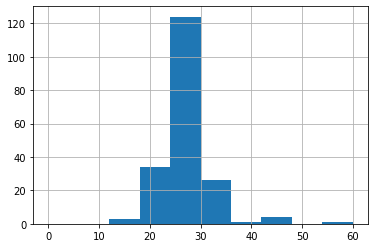

In [212]:
df.query('kitchen_area == 0.0 & rooms == 0')['total_area'].hist(range=(0, 60))

In [213]:
table = df.query('kitchen_area != 0.0').pivot_table(index='rooms', values = 'kitchen_area', aggfunc = ['count','mean', 'median']).reset_index()
table.columns = ('rooms', 'count', 'mean', 'median')
table

,rooms,count,mean,median
0,1,7213,9.550035,9.00
1,2,7286,9.979522,8.80
2,3,5380,11.308550,9.50
3,4,1081,13.664107,11.10
4,5,285,18.367719,15.10
5,6,97,21.048454,19.50
6,7,52,21.998077,20.00
7,8,9,24.866667,25.00
8,9,7,25.071429,14.30
9,10,3,22.866667,19.80


In [214]:
dict_kitchen = create_dict(need, table, 'rooms', 'mean')
dict_kitchen[0] = 0
dict_kitchen

{3: 11.3085501858736,
 1: 9.550034659642318,
 2: 9.97952237167168,
 4: 13.664107308048095,
 7: 21.998076923076926,
 5: 18.367719298245614,
 6: 21.048453608247428,
 8: 24.866666666666667,
 9: 25.071428571428573,
 0: 0}

Я поставила в 0 комнат площадь 0 м², т.к. эти квартиры по большей части до 30 м², т.е. мелкие, однокомнатные. Это видно в гистрограмме выше. Есть, правда, выбросы по общей площади. В таких квартирах кухни сожно выделить, обычно они очень небольшие и размазаны по площади.

In [215]:
def replace_kitchen(row):
    rooms = row['rooms']
    if row['kitchen_area'] == 0.0:
        return dict_kitchen.get(rooms)
    else:
        return row['kitchen_area']

In [216]:
df['kitchen_area'] = df.apply(replace_kitchen, axis = 1)

In [217]:
df['kitchen_area'].isna().sum()

0

#### Задача №7

In [218]:
df['balcony'] = df['balcony'].fillna(0)

In [219]:
obj_to_smt('balcony', 'int64')

Convert to int64 completed


In [220]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23699 non-null int64
last_price              23699 non-null int64
total_area              23699 non-null float64
first_day_exposition    23699 non-null datetime64[ns]
rooms                   23699 non-null int64
ceiling_height          23699 non-null float64
floors_total            23699 non-null object
living_area             23699 non-null float64
floor                   23699 non-null int64
is_apartment            23699 non-null bool
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            23699 non-null float64
balcony                 23699 non-null int64
locality_name           23699 non-null object
airports_nearest        18157 non-null object
cityCenters_nearest     18180 non-null object
parks_around3000        18181 non-null object
parks_nearest           8079 non-null object
ponds_around3000 

#### Задача №8

In [221]:
obj_to_smt('airports_nearest', 'float64')
df['airports_nearest'].isna().sum()

Convert to float64 completed


5542

In [222]:
df['cityCenters_nearest'] = df['cityCenters_nearest'].fillna(0)
obj_to_smt('cityCenters_nearest', 'float64')
df['cityCenters_nearest'].isna().sum()

Convert to float64 completed


0

In [223]:
df['parks_around3000'] = df['parks_around3000'].fillna(0)
obj_to_smt('parks_around3000', 'int64')
df['parks_around3000'].isna().sum()

Convert to int64 completed


0

In [224]:
df['ponds_around3000'] = df['ponds_around3000'].fillna(0)
obj_to_smt('ponds_around3000', 'int64')
df['ponds_around3000'].isna().sum()

Convert to int64 completed


0

In [225]:
obj_to_smt('parks_nearest', 'float64')
df['parks_nearest'].isna().sum()

Convert to float64 completed


15620

In [226]:
obj_to_smt('ponds_nearest', 'float64')
df['ponds_nearest'].isna().sum()

Convert to float64 completed


14589

In [227]:
df['days_exposition'] = df['days_exposition'].fillna(0)
obj_to_smt('days_exposition', 'int64')
df['days_exposition'].isna().sum()

Convert to int64 completed


0

После вашего комментария и перечитки задачи решила убрать замену на нули в колонках с расстояними до ближайшего аэропорта, пруда и парка. Там только привела к удобным типам данных. В днях и расстонии до центра решила оставить нули, т.к. для меня это памятка, что эти объявления еще не реализовались. На вебинаре рассказывали, что можно подобное проворачивать, ставя либо ноль, либо -999, к примеру. Я после в шаге 4 убирала выбивающиеся значение и это учла.

In [228]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23699 non-null int64
last_price              23699 non-null int64
total_area              23699 non-null float64
first_day_exposition    23699 non-null datetime64[ns]
rooms                   23699 non-null int64
ceiling_height          23699 non-null float64
floors_total            23699 non-null object
living_area             23699 non-null float64
floor                   23699 non-null int64
is_apartment            23699 non-null bool
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            23699 non-null float64
balcony                 23699 non-null int64
locality_name           23699 non-null object
airports_nearest        18157 non-null float64
cityCenters_nearest     23699 non-null float64
parks_around3000        23699 non-null int64
parks_nearest           8079 non-null float64
ponds_around300

### Вывод

Очень много данных люди не заполняют при подаче объявления, данные нельзя воссоздать, но я постаралась брать среднее или медиану. Либо заменяла нулями в целочисленных колонках, чтобы тип данных по колонке был одинаков.

## Шаг 3. Посчитайте и добавьте в таблицу

In [229]:
df['price_metr'] = round(df['last_price'] / df['total_area'])
df.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_metr
0,20,13000000,108.0,2019-03-07,3,2.7,16,51.0,8,False,...,0,Санкт-Петербург,18863.0,16028.0,1,482.0,2,755.0,0,120370.0
1,7,3350000,40.4,2018-12-04,1,2.8,11,18.6,1,False,...,2,Шушары,12817.0,18603.0,0,NaN,0,NaN,81,82921.0
2,10,5196000,56.0,2015-08-20,2,2.6,5,34.3,4,False,...,0,Санкт-Петербург,21741.0,13933.0,1,90.0,2,574.0,558,92786.0
3,0,64900000,159.0,2015-07-24,3,2.6,14,44.0,9,False,...,0,Санкт-Петербург,28098.0,6800.0,2,84.0,3,234.0,424,408176.0
4,2,10000000,100.0,2018-06-19,2,3.0,14,32.0,13,False,...,0,Санкт-Петербург,31856.0,8098.0,2,112.0,1,48.0,121,100000.0


In [230]:
df['weekday'] = df['first_day_exposition'].dt.weekday
df['month'] = pd.DatetimeIndex(df['first_day_exposition']).month
df['year'] = pd.DatetimeIndex(df['first_day_exposition']).year

In [231]:
dict_weekday={
    0: 'понедельник',
    1: 'вторник',
    2: 'среда',
    3: 'четверг',
    4: 'пятница',
    5: 'суббота',
    6: 'воскресенье'
}

In [232]:
def replace_weekday(row):
    return dict_weekday.get(row)

In [233]:
df['rus_weekday'] = df['weekday'].apply(replace_weekday)

In [234]:
dict_month={
    1: 'январь',
    2: 'февраль',
    3: 'март',
    4: 'апрель',
    5: 'май',
    6: 'июнь',
    7: 'июль',
    8: 'август',
    9: 'сентябрь',
    10: 'октябрь',
    11: 'ноябрь',
    12: 'декабрь'
}

In [235]:
def replace_month(row):
    return dict_month.get(row)

In [236]:
df['rus_month'] = df['month'].apply(replace_month)

In [237]:
def what_floor(row):
    if row['floor'] == 1:
        return 'первый'
    elif row['floors_total'] == row['floor']:
        return 'последний'
    elif row['floors_total'] == 'no_info':
        return 'неизвестно'
    else:
        return 'другой'

In [238]:
df['floor_of_flat'] = df.apply(what_floor, axis=1)

In [239]:
df['ratio_living'] = round(df['living_area'] / df['total_area'], 2)
df['ratio_kitchen'] = round(df['kitchen_area'] / df['total_area'], 2)

In [240]:
df.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,days_exposition,price_metr,weekday,month,year,rus_weekday,rus_month,floor_of_flat,ratio_living,ratio_kitchen
0,20,13000000,108.0,2019-03-07,3,2.7,16,51.0,8,False,...,0,120370.0,3,3,2019,четверг,март,другой,0.47,0.23
1,7,3350000,40.4,2018-12-04,1,2.8,11,18.6,1,False,...,81,82921.0,1,12,2018,вторник,декабрь,первый,0.46,0.27
2,10,5196000,56.0,2015-08-20,2,2.6,5,34.3,4,False,...,558,92786.0,3,8,2015,четверг,август,другой,0.61,0.15
3,0,64900000,159.0,2015-07-24,3,2.6,14,44.0,9,False,...,424,408176.0,4,7,2015,пятница,июль,другой,0.28,0.07
4,2,10000000,100.0,2018-06-19,2,3.0,14,32.0,13,False,...,121,100000.0,1,6,2018,вторник,июнь,другой,0.32,0.41


### Вывод

Я заменила числа на обычные названия дней недели и месяцы, чтобы было понятнее. Есть в соотношениях площади кухни к общей нули, т.к. на место пропусков у квартир с 0 комнат я подставила нулевое значение площади кухни. Всего таких случаев было 197 шт., думаю, что это не исказит общие данные

## Шаг 4. Проведите исследовательский анализ данных и выполните инструкции:

In [241]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 31 columns):
total_images            23699 non-null int64
last_price              23699 non-null int64
total_area              23699 non-null float64
first_day_exposition    23699 non-null datetime64[ns]
rooms                   23699 non-null int64
ceiling_height          23699 non-null float64
floors_total            23699 non-null object
living_area             23699 non-null float64
floor                   23699 non-null int64
is_apartment            23699 non-null bool
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            23699 non-null float64
balcony                 23699 non-null int64
locality_name           23699 non-null object
airports_nearest        18157 non-null float64
cityCenters_nearest     23699 non-null float64
parks_around3000        23699 non-null int64
parks_nearest           8079 non-null float64
ponds_around300

### Изучаем площадь, стоимость, количество комнат и высоту потолков

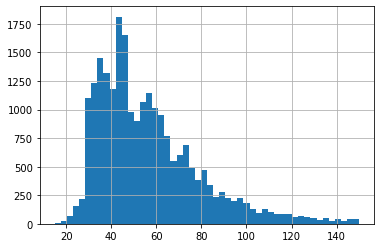

In [242]:
df['total_area'].hist(bins=50, range=(15, 150))

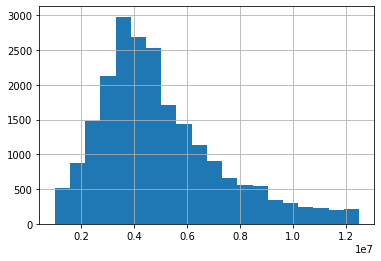

In [243]:
df['last_price'].hist(bins=20, range=(1000000,12500000))

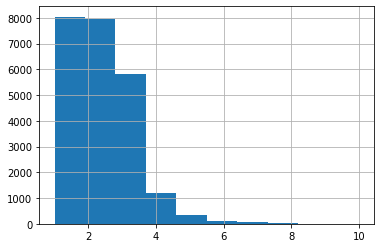

In [244]:
df['rooms'].hist(range=(1, 10))

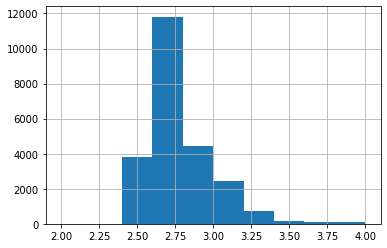

In [245]:
df['ceiling_height'].hist(range=(2, 4))

### Вывод

Я подбивала bins и range у гистограмм, чтобы было нагляднее видно значения
- Площадь. На гистрограмме видно, что большинство квартир до 50-60 м². Всплески есть примерно на 42-45 м².
- Стоимость. Очень много квартир в районе 4 млн. Это основной костяк
- Комнаты. 1-3 комнаты чаще всего встречаются. 4 есть у чуть более 1000 квартир, а больше 4 это редкость
- Высота потолков. Стандартная высота 2,7 м. Сюда вошли заполненные пропуски, поэтому так много квартир с этими данными. Больше 3,25 м высота уже редкая

## Дни продажи

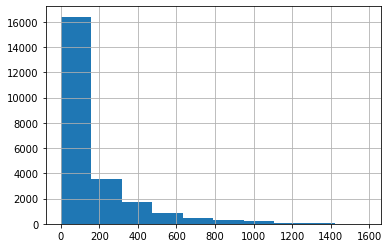

In [246]:
df['days_exposition'].hist()

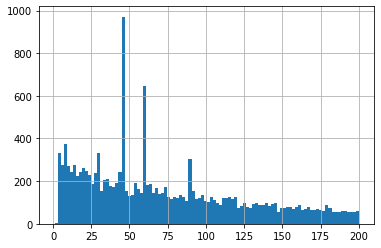

In [247]:
df['days_exposition'].hist(bins=100, range=(1, 200))

In [248]:
print('Среднее по колонке с днями продаж', round(df['days_exposition'].mean()))
print('Медиана по колонке с днями продаж', df['days_exposition'].median())

Среднее по колонке с днями продаж 157.0
Медиана по колонке с днями продаж 74.0


### Вывод

Я заменяла пропуски нулями и на первой гистограмме видно как столбец нулевой выбивается, поэтому на второй гистограмме я убрала ноль и поставила ограничение в 400 дней, чтобы лучше увидеть за сколько дней больше всего квартир продавались. Я вижу 2 пика: около 48 дней и около 60. Медиана и среднее значение еще больше: 74 и 157 дней соответственно. Среднее явно тянут выше выбросы, которые видны на первой гистограмме. Получается, что бошинство квартир продается за 2 месяца. Можно сказать, что если квартира продалась за месяц или еще меньше, то это очень быстрая продажа. Продажи же затягиваются, если объявление висит 200 и более дней.

## Убираем редкие и выбивающиеся значения

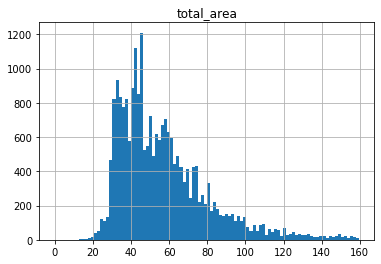

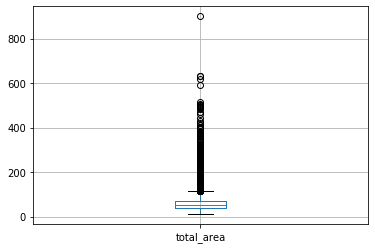

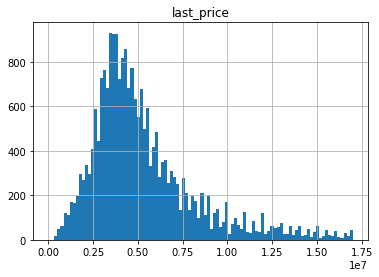

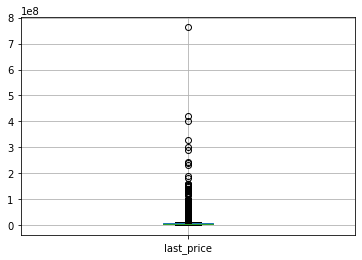

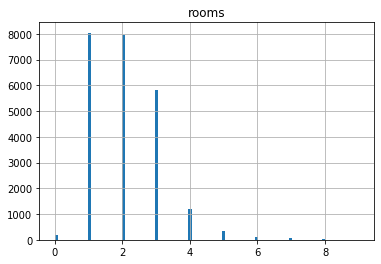

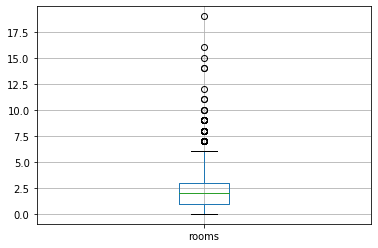

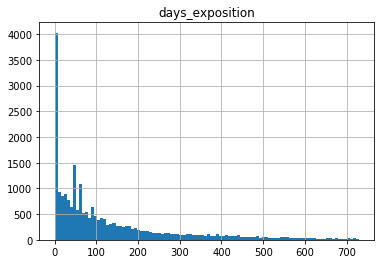

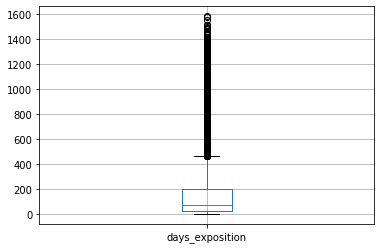

In [249]:
flat_data = df.loc[:, ['total_area', 'last_price', 'rooms', 'days_exposition']]
for column in flat_data:
    Q1 = flat_data[column].quantile(.25)
    Q3 = flat_data[column].quantile(.75)
    IQR = Q3 - Q1
    flat_data.hist(column, bins=100, range=(0, (Q3+3*IQR)))
    plt.show()
    flat_data.boxplot(column)

In [250]:
good_data = df.query('30 <= total_area < 60 & 2500000 < last_price < 7000000 & 2.5 <= ceiling_height <= 3.25 & 1 <= rooms <= 3 & 1 < days_exposition < 450 & cityCenters_nearest > 0')
good_data.describe()

,total_images,last_price,total_area,rooms,ceiling_height,living_area,floor,kitchen_area,balcony,airports_nearest,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_metr,weekday,month,year,ratio_living,ratio_kitchen
count,7842.000000,7.842000e+03,7842.000000,7842.000000,7842.000000,7842.000000,7842.000000,7842.000000,7842.000000,7835.000000,...,3099.000000,7842.000000,3493.000000,7842.000000,7842.00000,7842.000000,7842.000000,7842.000000,7842.000000,7842.000000
mean,9.458429,4.329691e+06,43.388358,1.536853,2.654737,23.864779,6.302601,8.763999,0.566820,29535.714997,...,477.632139,0.618847,546.987403,110.016832,100833.50153,2.576256,6.597934,2017.397730,0.543438,0.207749
std,5.374876,9.777166e+05,8.178959,0.639818,0.139323,7.598197,4.992852,2.689556,0.847021,13502.486265,...,312.324273,0.817621,275.599913,105.169554,19129.01292,1.788273,3.471664,0.827755,0.104300,0.067763
min,0.000000,2.530000e+06,30.000000,1.000000,2.500000,2.000000,1.000000,2.000000,0.000000,6450.000000,...,1.000000,0.000000,19.000000,2.000000,47957.00000,0.000000,1.000000,2015.000000,0.040000,0.060000
25%,6.000000,3.600000e+06,36.800000,1.000000,2.600000,17.400000,3.000000,6.800000,0.000000,17452.000000,...,288.000000,0.000000,335.000000,33.000000,87622.75000,1.000000,3.000000,2017.000000,0.470000,0.150000
50%,9.000000,4.200000e+06,43.000000,1.000000,2.600000,20.500000,5.000000,8.500000,0.000000,28596.000000,...,451.000000,0.000000,535.000000,70.000000,99033.00000,3.000000,7.000000,2017.000000,0.550000,0.200000
75%,13.000000,4.950000e+06,50.000000,2.000000,2.700000,30.000000,9.000000,10.000000,1.000000,39892.000000,...,604.000000,1.000000,756.000000,155.000000,111905.00000,4.000000,10.000000,2018.000000,0.620000,0.260000
max,30.000000,6.999000e+06,59.900000,3.000000,3.200000,54.000000,31.000000,30.000000,5.000000,83758.000000,...,3190.000000,3.000000,1344.000000,449.000000,209375.00000,6.000000,12.000000,2019.000000,1.060000,0.790000


### Вывод

Апдейт после изменений: здесь я убираю очень старые объявления, слишком большие и маленькие по площади, с высокими потолками и рассматриваю максимум 3-комнатные объекты. Добавила еще рамки по цене, чтобы слишком дорогие квартиры не повлияли на результат. Т.к. в колонках расстонияе до аэропорта и до центра убрала замену на 

## Факторы, влияющие на стоимость квартиры

In [251]:
good_data.corr()['last_price'].sort_values(ascending=False)

last_price             1.000000
price_metr             0.595297
total_area             0.584185
living_area            0.336484
kitchen_area           0.305210
rooms                  0.276549
ceiling_height         0.249771
total_images           0.181881
floor                  0.144466
balcony                0.112056
year                   0.102322
parks_nearest          0.040613
parks_around3000       0.040192
is_apartment           0.030816
ponds_around3000       0.029592
days_exposition        0.020705
open_plan              0.005342
month                  0.001546
ponds_nearest          0.000913
studio                -0.005386
weekday               -0.012705
ratio_living          -0.018296
airports_nearest      -0.020316
ratio_kitchen         -0.044648
cityCenters_nearest   -0.330217
Name: last_price, dtype: float64

In [252]:
def get_scatter(data, column, alpha):
    data.plot(x=column, y='last_price', kind='scatter', alpha=alpha)    
def get_hexbin(data, column):
    data.plot(x=column, y='last_price', kind='hexbin', gridsize=15, figsize=(7, 5), sharex=False, grid=True)

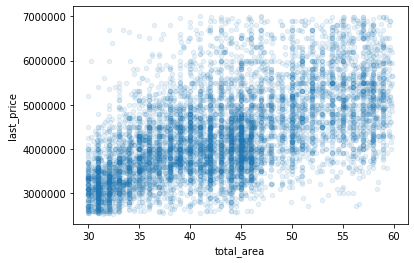

In [253]:
get_scatter(good_data,'total_area', 0.1)

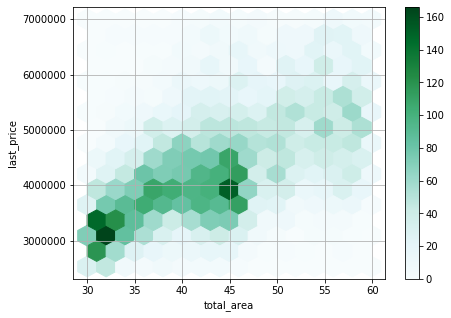

In [254]:
get_hexbin(good_data,'total_area')

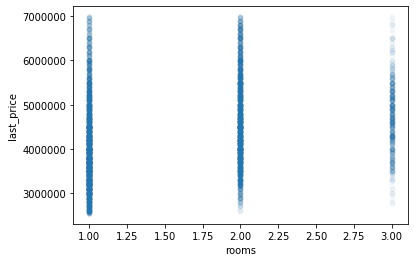

In [255]:
get_scatter(good_data, 'rooms', 0.03)

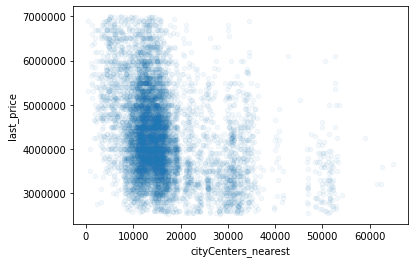

In [256]:
get_scatter(good_data, 'cityCenters_nearest', 0.05)

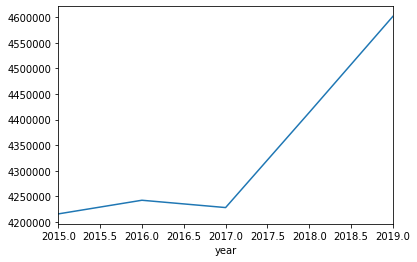

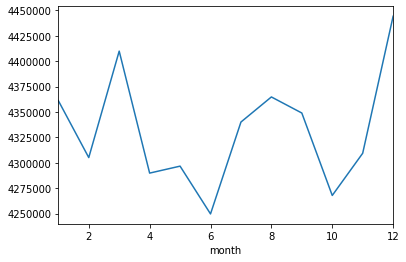

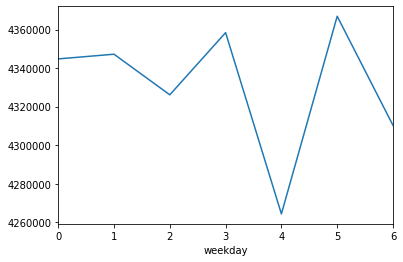

In [257]:
columns = ['year', 'month', 'weekday']
for col in columns:
    good_data.groupby(col)['last_price'].agg('mean').plot()
    plt.show()    

### Вывод

Апдейд после изменений: по таблице с корреляцией видно, что наибольшее влияние имеет площадь квартиры. Дальше закономерно цена за квадратный метр, жилая площадь, площадь кухни и количество комнат. Чем больше метров или комнат, тем больше цена. Еще есть обратная зависимость цены от удаленности от центра. Чем больше расстояние, тем меньше цена на квартиру. Но нельзя сказать, что взаимосвязи сильные, т.к. самое больше значение коэффициента Пирсона = 0,59 у площадиквадратного метра и 0,58 у площади кватиры. Близких к 1 или -1 у нас нет. Скорее всего здесь не линейная зависимость, надо рассмотреть подбронее в графиках.


Графики зависимости цены:

- от площади: зависимость есть, немного ступенчатая, если можно так выразиться. Эти ступени видно на 30 м², 45 м² и 60 м² на втором графике. Похоже это из-за представления о цене определенных площадей у продавцов квартир. Пример: квартира 30 м² должна стоит 3-3,2 млн. руб., а квартира на 45 м² - 4 млн.руб. Относительно этих сумм остальные выставляли свои цены.
- от количества комнат: чем больше комнат, тем выше будет минимальная цена квартиры. Но вот максимальная может быть одинаковой как у 1-комнатной квартиры, так и у 3-комнатной. Хотя количество последних меньше.
- от удаленности от центра: на гистрограмме видно, что условная линия стремиться вниз, т.е. чем дальше от центра, тем цена меньше.
- от года размещения: средняя цены с 2017 стремительно уходит вверх. с 2017 было увеличение средних значений цены на 400 тыс.руб.
- от месяца размещения: зависимость средней цены от месяца скачет. С марта мы видим падение цен к июню, дальше к августу снова рост, небольшое падение к октябрю и подорожание в декабре. У нас данные по последней цене продажи есть предположение, что цену снижают к лету, т.к объявление висит достаточно долго(если считать с начала года) и продавцы хотят продать быстрее свою собтвенность. Это можно было бы проверить, если бы данные были по динамике изменения цен. 
- от дня недели: самые низкие цены видны в пятницу.

## ТОП-10 городов

In [258]:
pivot_good = good_data.pivot_table(index='locality_name', values='price_metr', aggfunc=['count', 'mean'])
pivot_good.columns = ('count_flat', 'mean_price_metr')
top10 = pivot_good.sort_values(by='count_flat', ascending=False).head(10)
top10

,count_flat,mean_price_metr
locality_name,,
Санкт-Петербург,6604,103575.569352
Шушары,200,82531.290000
Парголово,192,93437.432292
Колпино,190,77263.836842
Пушкин,164,98120.579268
Петергоф,113,83137.849558
Сестрорецк,76,103443.763158
Красное Село,73,74697.424658
Ломоносов,53,72954.547170


In [259]:
top10.sort_values(by='mean_price_metr', ascending=False)

,count_flat,mean_price_metr
locality_name,,
Санкт-Петербург,6604,103575.569352
Сестрорецк,76,103443.763158
Пушкин,164,98120.579268
Парголово,192,93437.432292
Кронштадт,48,83258.645833
Петергоф,113,83137.849558
Шушары,200,82531.290000
Колпино,190,77263.836842
Красное Село,73,74697.424658


### Вывод

Апдейд после изменений: как и ожидалось в Санкт-Петербурге, центре Лен.области, стоимость жилья будет самой больше и также самое большое число объявлений о продаже. Но неожиданно в городе Сестрорецк на северо-западе области цена ниже всего на 131 руб., а объявлений почти в 87 раз меньше. Скорее всего, это из-за географического расположения. Этот город находится в Курортном районе. С одной стороны Финский залив, а с другой - озеро. Город же с самой низкой стоимостью жилья - Ломоносов, по количеству объявлений он на предпоследнем месте.

## Центр Санкт-Петербурга

In [260]:
flat_sp = good_data.copy()
flat_sp['cityCentr_kl'] = round(flat_sp['cityCenters_nearest'] / 1000)
flat_sp = flat_sp.query('locality_name == "Санкт-Петербург"')

In [261]:
mean_price_kl = flat_sp.pivot_table(index='cityCentr_kl', values='last_price', aggfunc=['mean']).reset_index()
mean_price_kl.columns = ('kilometr', 'mean_price')
mean_price_kl.head()

,kilometr,mean_price
0,0.0,6.100000e+06
1,1.0,5.507500e+06
2,2.0,5.302615e+06
3,3.0,5.121809e+06
4,4.0,5.396338e+06


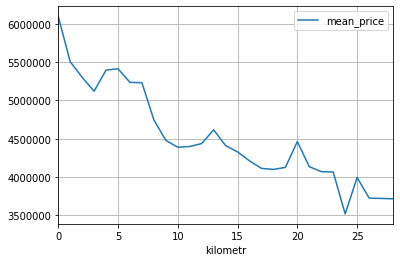

In [262]:
mean_price_kl.plot(x='kilometr', y='mean_price', grid=True)

In [263]:
centr_sp = flat_sp.query('cityCentr_kl <= 9.0 & floor_of_flat != "неизвестно"')
centr_sp.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,price_metr,weekday,month,year,rus_weekday,rus_month,floor_of_flat,ratio_living,ratio_kitchen,cityCentr_kl
70,9,3400000,30.0,2018-09-05,1,2.6,5,16.0,1,False,...,113333.0,2,9,2018,среда,сентябрь,первый,0.53,0.23,8.0
85,13,5200000,46.3,2018-11-26,2,3.0,5,27.8,5,False,...,112311.0,0,11,2018,понедельник,ноябрь,последний,0.60,0.17,9.0
111,4,4590000,40.0,2017-05-29,1,3.0,6,18.0,1,False,...,114750.0,0,5,2017,понедельник,май,первый,0.45,0.25,6.0
115,8,3850000,42.0,2018-11-05,2,2.6,5,27.0,4,False,...,91667.0,0,11,2018,понедельник,ноябрь,другой,0.64,0.15,9.0
118,8,4500000,31.0,2019-02-24,1,2.5,9,17.0,4,False,...,145161.0,6,2,2019,воскресенье,февраль,другой,0.55,0.16,9.0


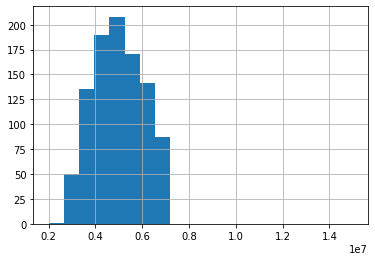

In [264]:
centr_sp['last_price'].hist(bins=20, range=(2000000, 15000000))

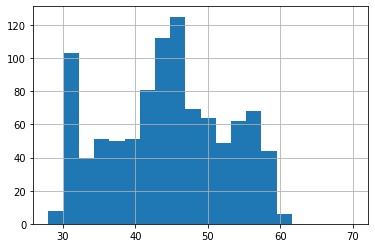

In [265]:
centr_sp['total_area'].hist(bins=20,range=(28,70))

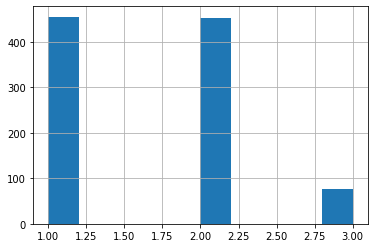

In [266]:
centr_sp['rooms'].hist()

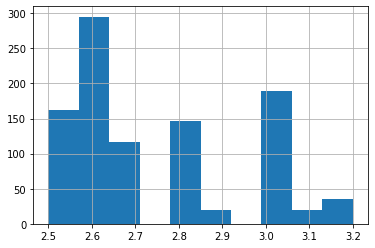

In [267]:
centr_sp['ceiling_height'].hist()

##### Зависимости цены квартиры в центре Питера от факторов

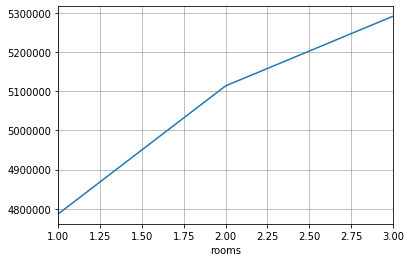

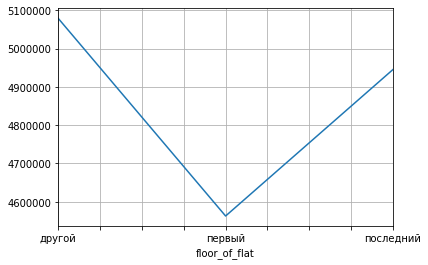

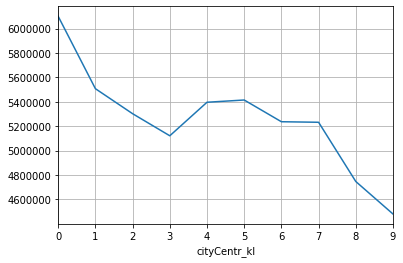

In [268]:
columns = ['rooms', 'floor_of_flat', 'cityCentr_kl']
for col in columns:
    centr_sp.groupby(col)['last_price'].agg('mean').plot(grid=True)
    plt.show()   

Не понимаю почему код выдавал ошибку. Прогнала еще раз с самого начала, ничего не меняя, и график появился как и другие. Но по вашей рекомендации я поменяла график на линейный. Тоже самое сделала с комнатами и удаленностью от центра через цикл.

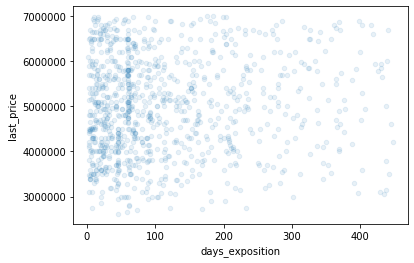

In [269]:
get_scatter(centr_sp,'days_exposition', 0.1)

### Вывод

Апгрейд после изменений: по цене условный центр явно вырисовывается в пределах 9 км. По большей части в центре квартиры 1 и 2-комнатные. А вот цены на порядок выше остальных частей Питера, хотя есть и дешевые варианты. По площади встречаются в основном 40-45 м², но есть и маленькие около 30 м². Ограничение в  60+ м² было неожиданностью, т.к. есть квартиры и большей площади в других местах. По высоте после замены на медиану получилось, что больше всего квартир с высотой 2,6 м, а больше 3 м уже редкость.  

- Количество комнат. Как и ожидалось, чем больше количество комнат, тем цена выше. Но это распространяется на нижний порог стоимости, а не на верхний. 1-комнатная квартира может примерно стоит как 2-комнатная в центре.
- Этаж. В центре последний этаж не так сильно уступает в цене как "другой". Но как и в целом по Санкт-Петербургу цены на первый этаж ниже. 
- Удаленность от центра. Тут присутствует зависимость, чем ближе к центру, тем стоимость выше. У тех объектов, что находятся совсем рядом с центром(до 3 км), цена от 5,1 млн. руб. В это же время чем дальше от центра, тем цена опускается.
- Дни размещения. Тут мне не совсем понятна зависимость. Довольно много объектов по разным ценам были опубликованны не более 100 дней. Если бы была положительная корреляция между этими двумя параметрами, то график был бы другой: самые дешевые объекты продавались бы быстрее, но тут эта связь не очевидна.

### Шаг 5. Общий вывод

1. Чем больше площадь объекта, тем он дороже. Это самый важный фактор, за которым нужно следить, при выявлении мошеничества. В среднем квартиры 30-35 м² самые дешевые от 2,5 млн.руб.
    - Количество комнат тоже влияет на стоимость недвижимости, это вытекающий из площади фактор. У 4-комнатных квартрир видно, что минимальная цена в районе 3 750 000 руб., тогда как у 1-комнатных - меньше 2 500 000 руб. Но количество комнат не всегда указывают.
2. Удаленность от центра в центре области имеет больше значение для формирования цены. Чем ближе к центру, тем дороже. Поэтому квартира в радиусе 9 км от центра не будет стоит 2 млн.руб. Скорее 4-5 млн. и выше.
    - Курортный район выделился также стоимостью. Тут уровень цен близок к Санкт-Петербургу, поэтому небольшая стоимость будет тревожным сингалом для объектов этого района.